## Import libraries

- pipenv --python 3.11.9
- pipenv install -r requeriments.txt
- pipenv shell

In [1]:
from __future__ import division
from datetime import datetime
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

## Configuration matplotlib

In [2]:
#magic command
%matplotlib inline


## Load data
Add the stocks interested and downloads their historical data for the las 4 years from current date using the yfinance library (yahoo finance). Save data in a dictionary.

In [3]:
stock_list = ['AXI1.F','GFT.F','CGM.F','SPSAF','CSA.F','NT5.F']

end = datetime.now()

#Start date set to 4 year back
start = datetime(end.year-4,end.month,end.day) 

data_dict = {}

for stock in stock_list:
    data_dict[stock] = yf.download(stock,start,end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Example of EDA with a stock 

In [4]:
nttdata = data_dict['NT5.F']
atos = data_dict['AXI1.F']
gft = data_dict['GFT.F']
capgemini = data_dict['CGM.F']
sopra = data_dict['SPSAF']
accenture = data_dict['CSA.F']

In [5]:
nttdata.describe()

Price,Close,High,Low,Open,Volume
Ticker,NT5.F,NT5.F,NT5.F,NT5.F,NT5.F
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,2.094441,2.095244,2.086477,2.087131,60.611926
std,5.381657,5.384369,5.356030,5.358175,480.757832
min,0.000034,0.000034,0.000034,0.000034,0.000000
25%,0.000202,0.000203,0.000202,0.000203,0.000000
50%,0.019819,0.019819,0.019819,0.019819,0.000000
75%,0.874162,0.874162,0.871006,0.871006,0.000000
max,24.600000,24.600000,24.400000,24.400000,14442.000000


In [6]:
nttdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1023 entries, 2021-07-05 to 2025-07-04
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, NT5.F)   1023 non-null   float64
 1   (High, NT5.F)    1023 non-null   float64
 2   (Low, NT5.F)     1023 non-null   float64
 3   (Open, NT5.F)    1023 non-null   float64
 4   (Volume, NT5.F)  1023 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 48.0 KB


### Plot time series line chart of the stock's closing price over the entire available date range. 

<Axes: xlabel='Date'>

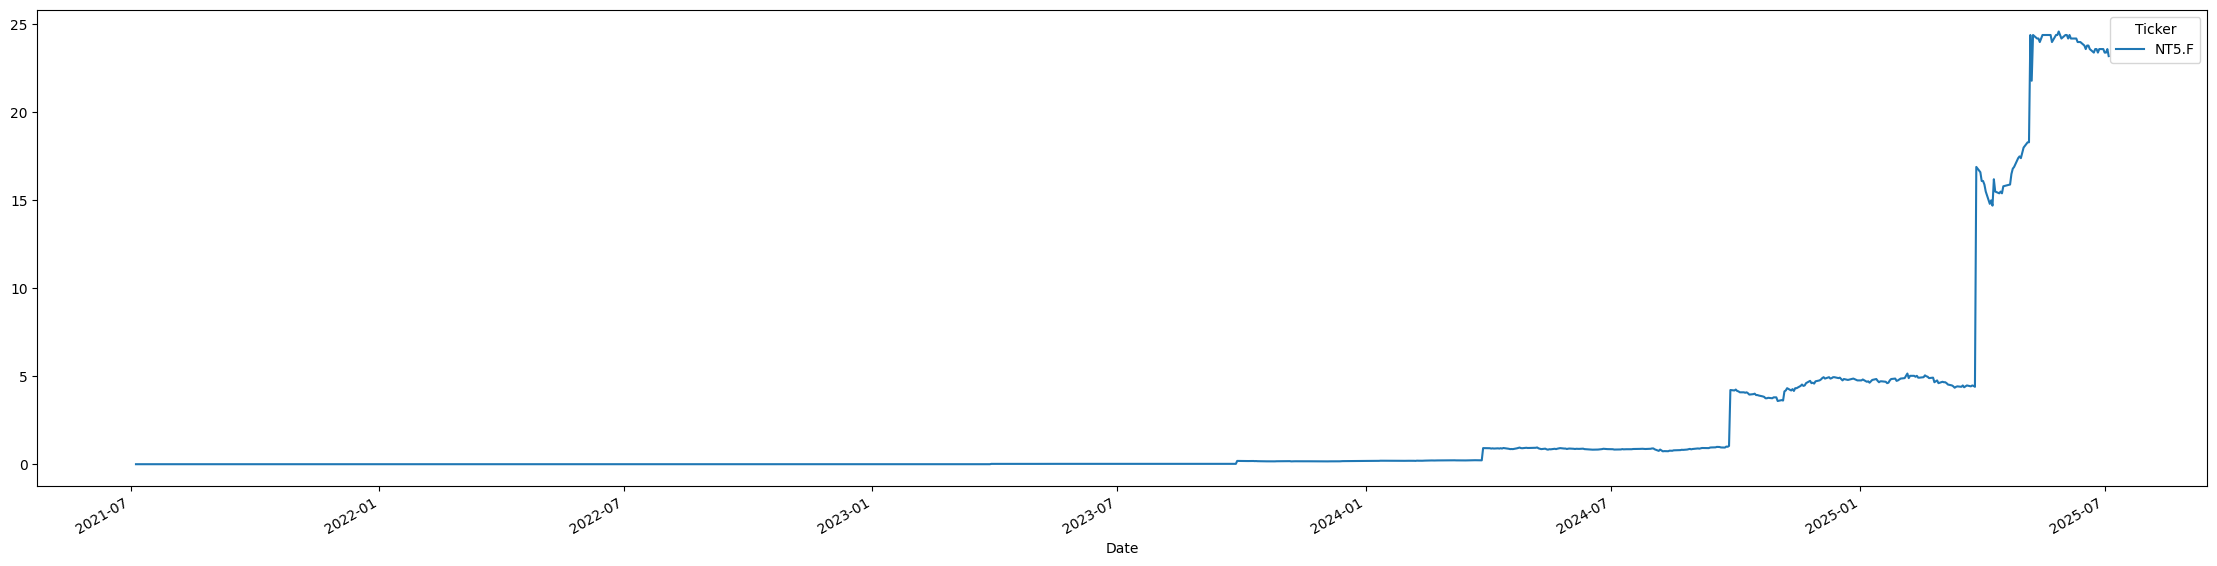

In [7]:
nttdata['Close'].plot(legend = True, figsize = (28,7))

### Plot time series of daily trading volume over the entire available date range. 

<Axes: xlabel='Date'>

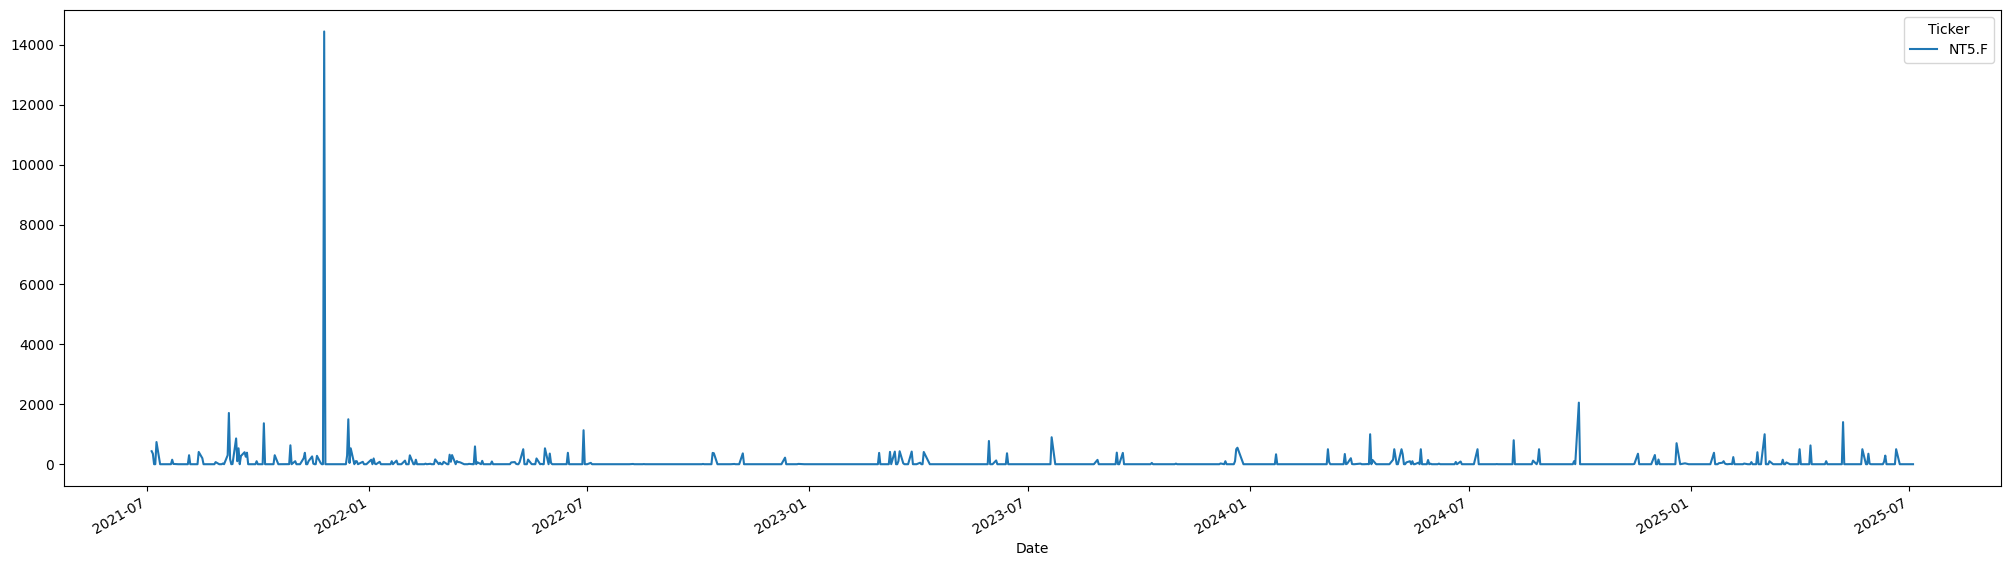

In [8]:
nttdata['Volume'].plot(legend = True, figsize = (25,7))

### Calculates moving averages of the closing price for 10, 25, and 50 days and adds these as new columns in the DataFrame. Moving averages are commonly used in finance to identify trends and support/resistance levels in stock prices.

In [9]:
averages = [10,25,50]
for avg in averages:
    label = "MAvg for %s days" %(str(avg))
    nttdata[label] = nttdata['Close'].rolling(window = avg, center = False).mean()

In [10]:
nttdata.tail()

Price,Close,High,Low,Open,Volume,MAvg for 10 days,MAvg for 25 days,MAvg for 50 days
Ticker,NT5.F,NT5.F,NT5.F,NT5.F,NT5.F,,,
Date,,,,,,,,
2025-06-30,23.600000,23.600000,23.600000,23.600000,0,23.60,23.976,22.516
2025-07-01,23.400000,23.400000,23.400000,23.400000,0,23.58,23.936,22.668
2025-07-02,23.400000,23.400000,23.400000,23.400000,0,23.54,23.888,22.818
2025-07-03,23.600000,23.600000,23.400000,23.400000,3,23.52,23.856,22.960
2025-07-04,23.200001,23.200001,23.200001,23.200001,0,23.48,23.816,23.088


### Plot time series line chart of the stock's closing price, MAvg(10,25,50 days) over the entire available date range. 

<Axes: xlabel='Date'>

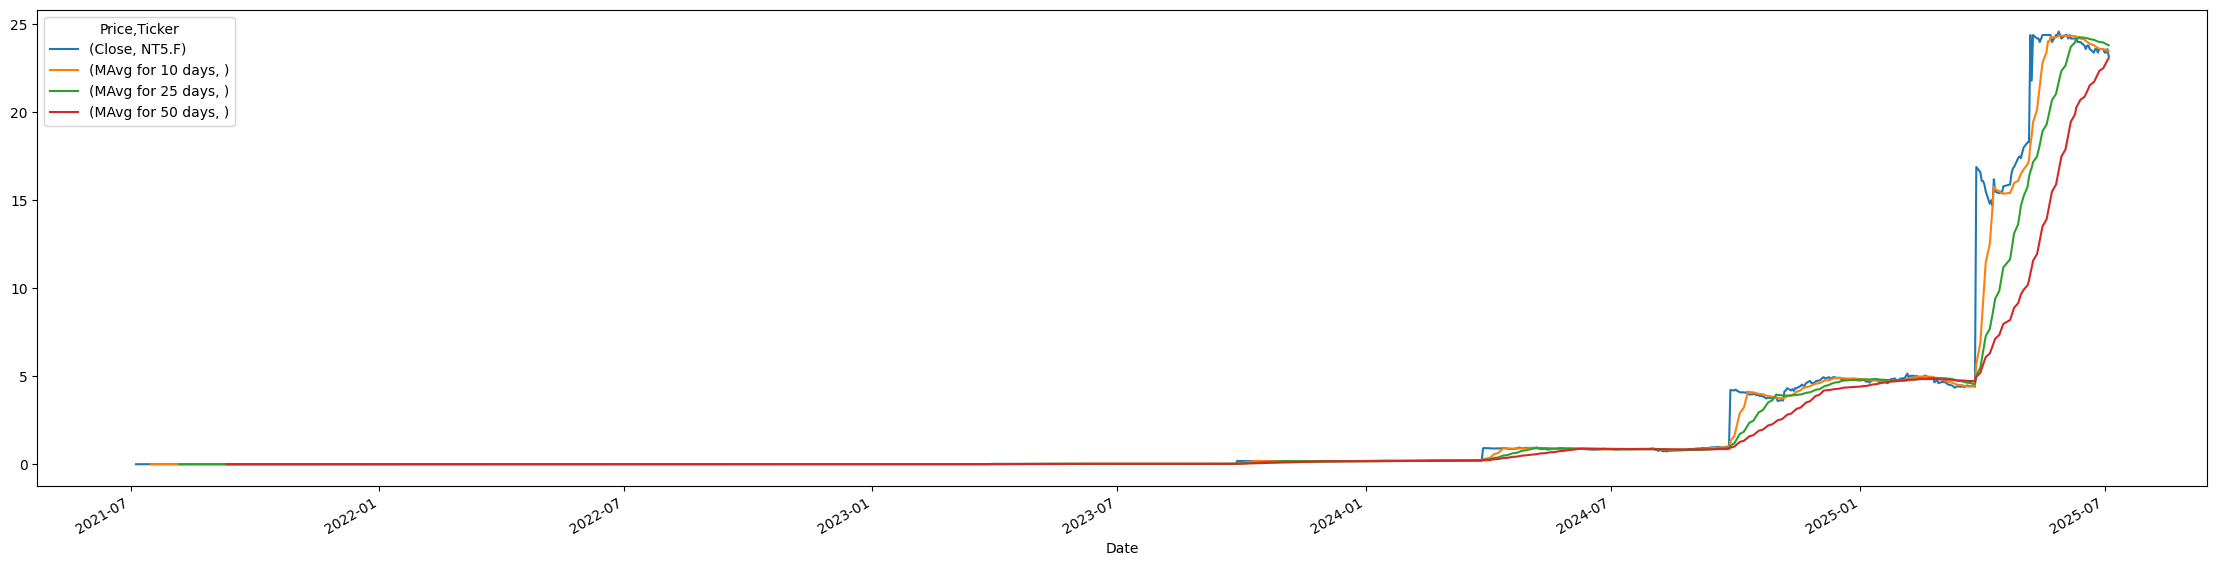

In [11]:
nttdata[['Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(subplots = False, figsize = (28,7))

### We calculate the daily percentage change of the closing price.
For each day, it compares the closing price with the previous day’s closing price and computes how much it changed in percentage.

In [12]:
nttdata['Daily Return'] = nttdata['Close'].pct_change()
nttdata.tail()

Price,Close,High,Low,Open,Volume,MAvg for 10 days,MAvg for 25 days,MAvg for 50 days,Daily Return
Ticker,NT5.F,NT5.F,NT5.F,NT5.F,NT5.F,,,,
Date,,,,,,,,,
2025-06-30,23.600000,23.600000,23.600000,23.600000,0,23.60,23.976,22.516,0.000000
2025-07-01,23.400000,23.400000,23.400000,23.400000,0,23.58,23.936,22.668,-0.008475
2025-07-02,23.400000,23.400000,23.400000,23.400000,0,23.54,23.888,22.818,0.000000
2025-07-03,23.600000,23.600000,23.400000,23.400000,3,23.52,23.856,22.960,0.008547
2025-07-04,23.200001,23.200001,23.200001,23.200001,0,23.48,23.816,23.088,-0.016949


### Plot time series line chart of the stock's Daily Return over the entire available date range. 

<Axes: xlabel='Date'>

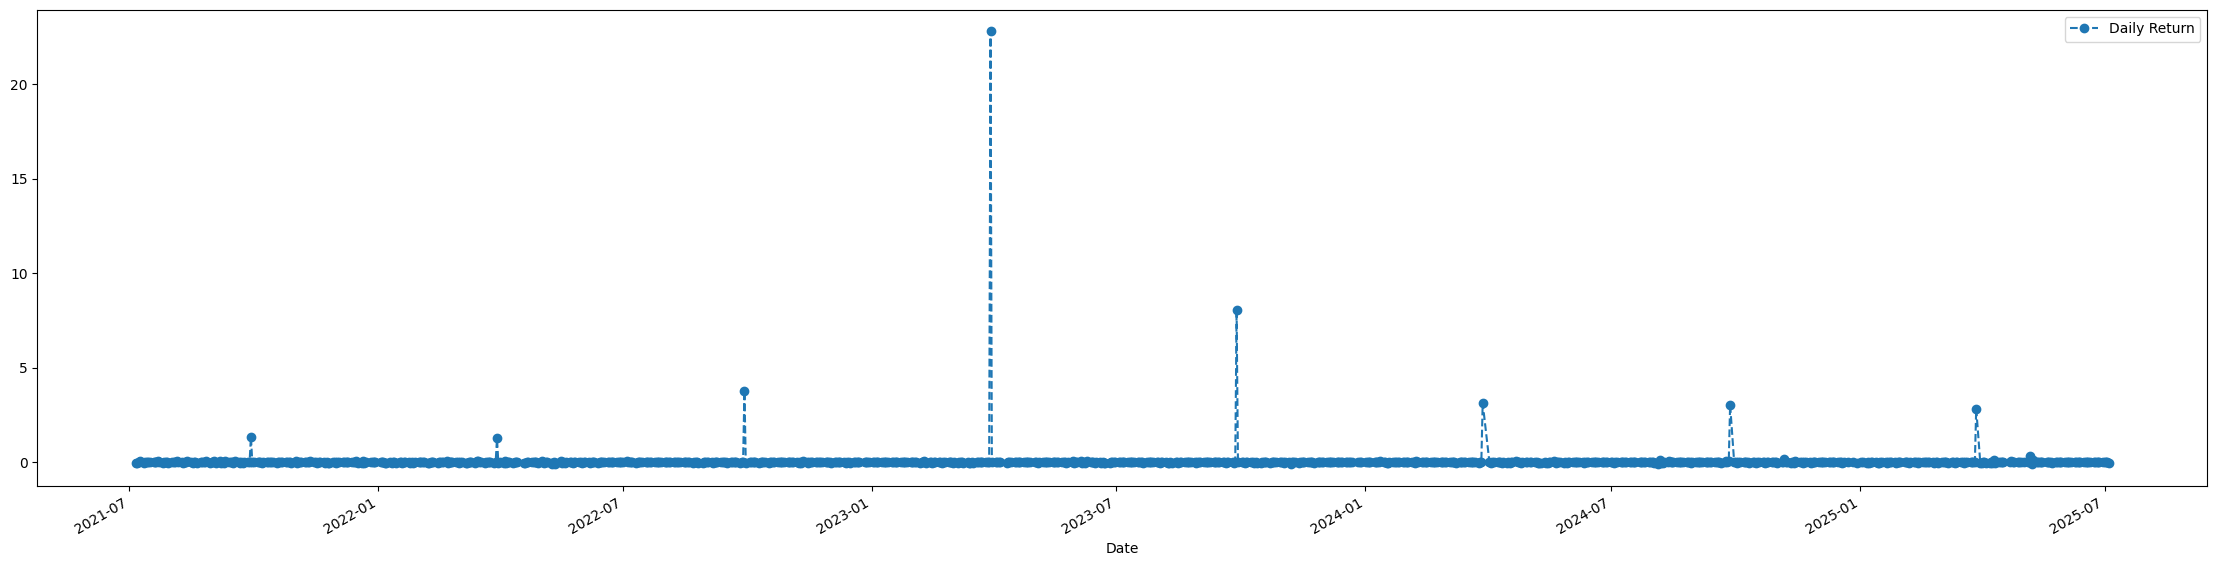

In [13]:
nttdata['Daily Return'].plot(figsize=(28,7),legend=True,linestyle='--',marker='o')

By converting prices to daily returns, we can analyze relative changes, compare different stocks on the same scale, and use this data for risk and performance analysis or modeling.

In [14]:
close_compr = yf.download(stock_list,start,end)['Close']
rets_compr = close_compr.pct_change()
rets_compr.tail()

[*********************100%***********************]  6 of 6 completed


Ticker,AXI1.F,CGM.F,CSA.F,GFT.F,NT5.F,SPSAF
Date,,,,,,
2025-06-30,-0.013076,0.022136,0.006352,0.108647,0.000000,0.0
2025-07-01,-0.026341,-0.003438,0.013807,0.000000,-0.008475,0.0
2025-07-02,0.004050,0.005519,-0.010117,-0.008000,0.000000,0.0
2025-07-03,-0.013391,-0.004803,0.017099,-0.024193,0.008547,0.0
2025-07-04,0.015536,0.002413,-0.005024,-0.039256,-0.016949,0.0


Compare daily percentage change of the closing price of stocks NT5.F and GFT.F (the closing price with the previous day’s closing price and computes how much it changed in percentage).

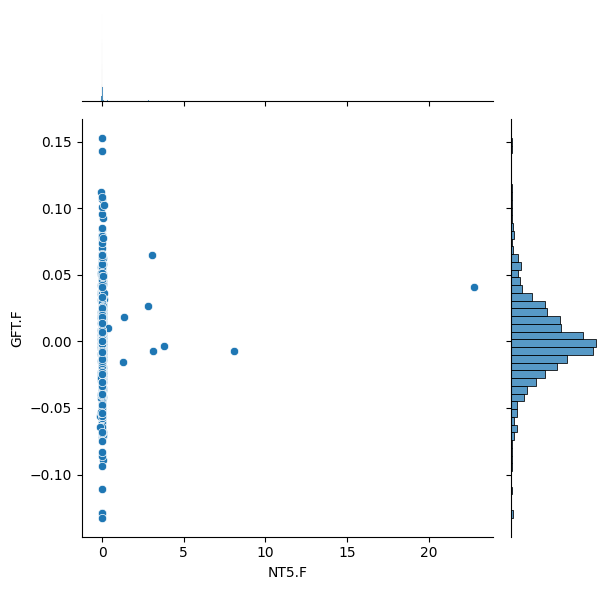

In [15]:
sns.jointplot(x='NT5.F', y='GFT.F', data=rets_compr, kind='scatter', height=6, ratio=4)


Compare daily percentage change of the closing price of all stocks 

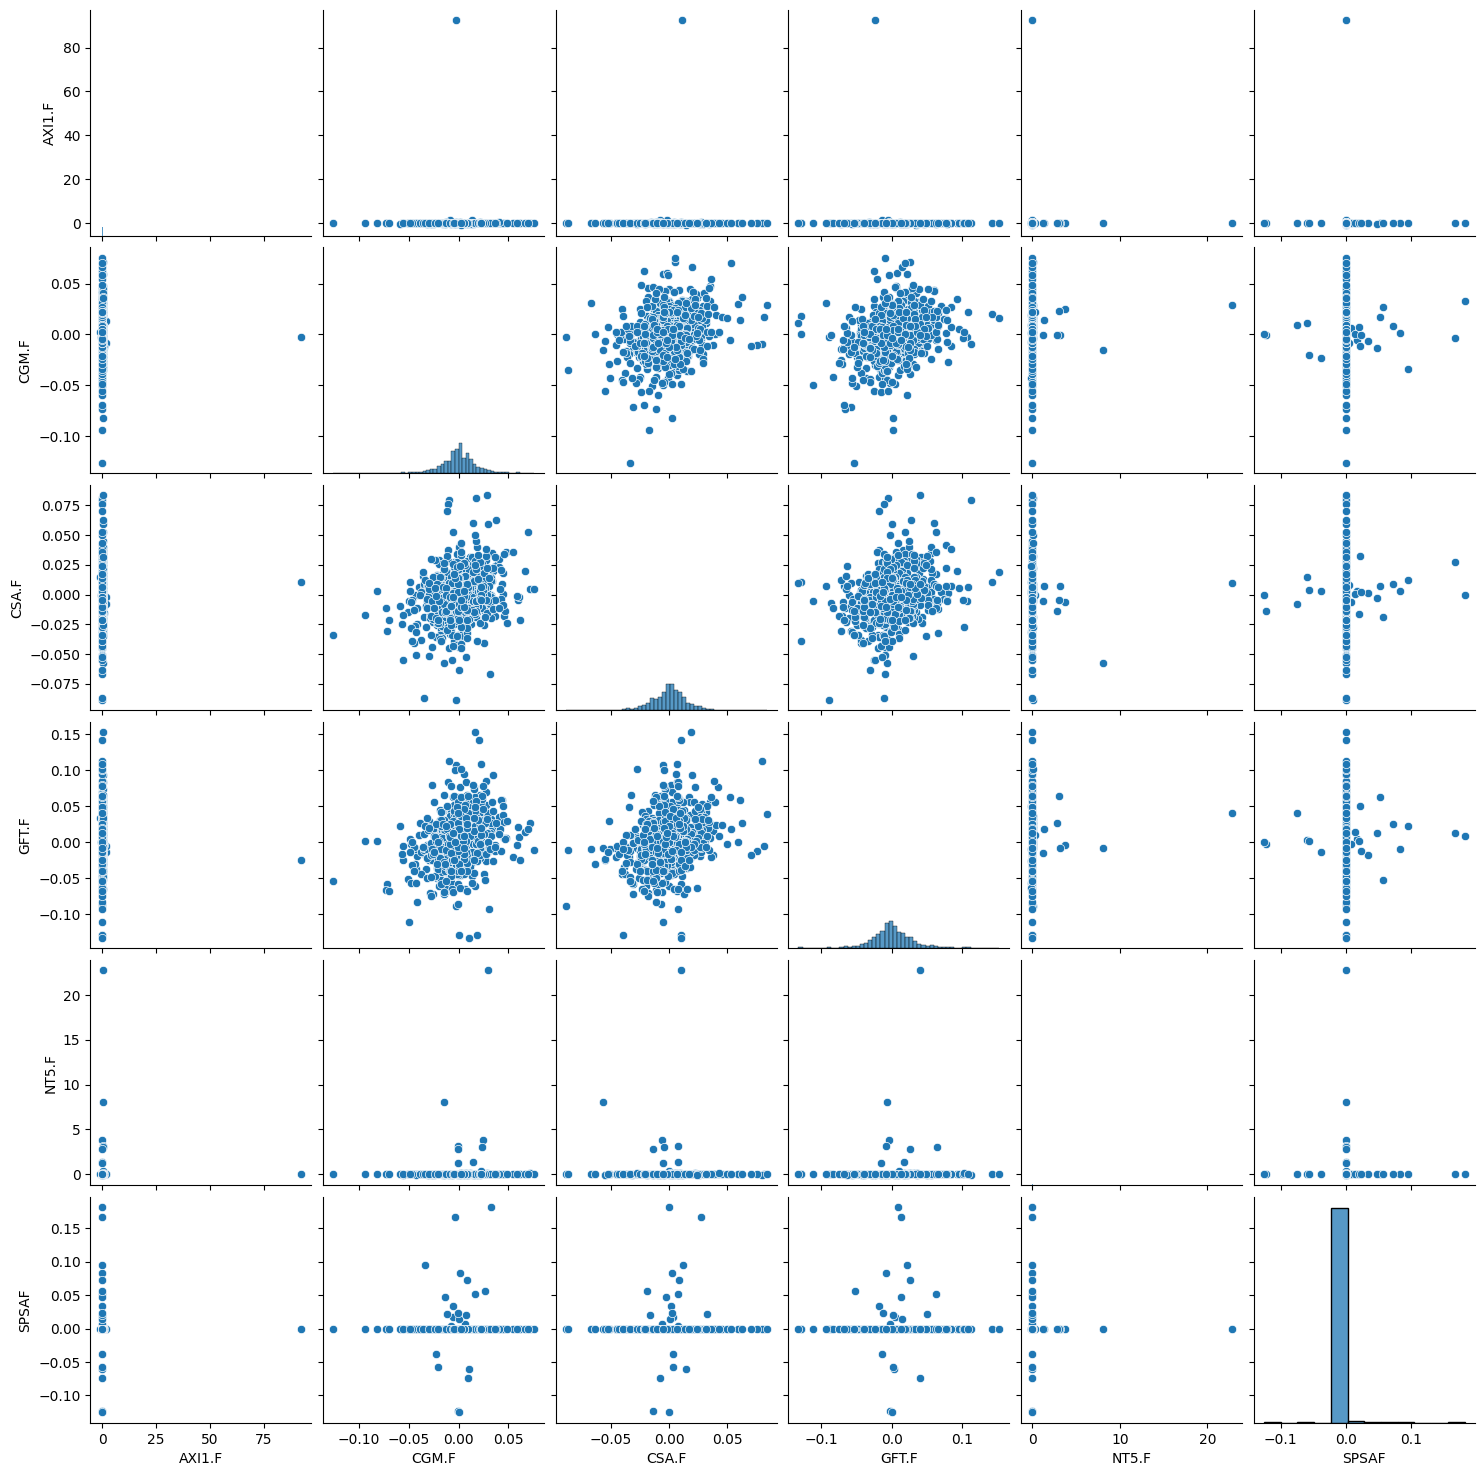

In [16]:
sns.pairplot(rets_compr.dropna())

We create a heatmap showing how daily returns of different stocks are correlated. You can easily see which pairs move similarly (strong positive correlation), oppositely (negative correlation), or independently (near zero correlation).

Ticker    AXI1.F     CGM.F     CSA.F     GFT.F     NT5.F     SPSAF
Ticker                                                            
AXI1.F  1.000000 -0.000509  0.020090 -0.024433  0.000115 -0.001270
CGM.F  -0.000509  1.000000  0.270412  0.281816  0.053053  0.022022
CSA.F   0.020090  0.270412  1.000000  0.274865 -0.018276  0.035415
GFT.F  -0.024433  0.281816  0.274865  1.000000  0.049684  0.016369
NT5.F   0.000115  0.053053 -0.018276  0.049684  1.000000 -0.002643
SPSAF  -0.001270  0.022022  0.035415  0.016369 -0.002643  1.000000


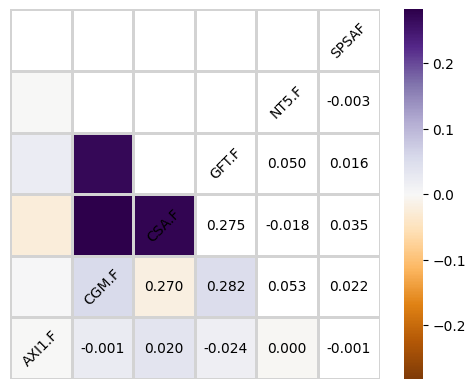

In [17]:
corr = rets_compr.corr()
print(corr)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots()

vmax = np.abs(corr.values[~mask]).max()
sns.heatmap(corr, mask=mask, cmap=plt.cm.PuOr, vmin=-vmax, vmax=vmax,
            square=True, linecolor="lightgray", linewidths=1, ax=ax)
for i in range(len(corr)):
    ax.text(i+0.5,len(corr)-(i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45)
    for j in range(i+1, len(corr)):
        s = "{:.3f}".format(corr.values[i,j])
        ax.text(j+0.5,len(corr)-(i+0.5),s, 
            ha="center", va="center")
ax.axis("off")
plt.show()

We generate a Risk vs Expected Return scatter plot for a set of financial assets. It calculates the daily average returns and daily volatility (standard deviation) for each asset based on their historical price returns.

To improve visualization, it adds a small random noise ("jitter") to avoid overlapping points.

Each asset is plotted as a point where:

The x-axis represents the expected (average) return.

The y-axis represents the risk (volatility).

A subset of assets is highlighted with labels and arrows for easy identification. The plot includes a legend, grid, and customized axis limits to give a clear visual comparison of risk and return profiles among the assets.

This helps investors understand the trade-off between risk and return across different assets.

- Top right (high expected return, high risk):
These assets can offer higher potential gains but with high volatility. Suitable for investors with high risk tolerance.

- Top left (low expected return, high risk):
An undesirable position — high risk but low expected returns. Usually best to avoid these assets.

- Bottom right (high expected return, low risk):
Ideal scenario — good returns with low volatility. Very attractive assets for most investors.

- Bottom left (low expected return, low risk):
Conservative assets with low volatility and low returns. Useful for capital preservation or defensive portfolios.

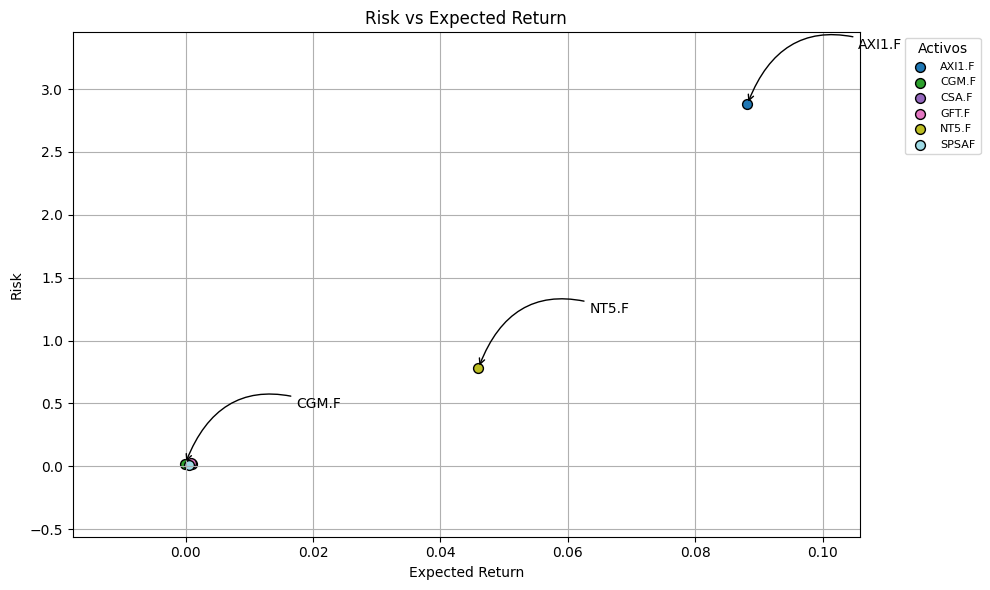

In [18]:
rets_filled = rets_compr.dropna()

plt.figure(figsize=(10, 6))

means = rets_filled.mean()
stds = rets_filled.std()

means_jittered = means + np.random.normal(0, 0.0005, size=means.shape)
stds_jittered = stds + np.random.normal(0, 0.0005, size=stds.shape)

all_labels = rets_filled.columns
highlight_labels = ['CGM.F', 'AXI1.F', 'NT5.F']

colors = plt.cm.tab20(np.linspace(0, 1, len(all_labels)))

for i, label in enumerate(all_labels):
    x = means_jittered[label]
    y = stds_jittered[label]
    plt.scatter(x, y, color=colors[i], s=50, edgecolors='black', label=label)

for label in highlight_labels:
    if label in rets_filled.columns:
        x = means_jittered[label]
        y = stds_jittered[label]
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(80, 40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='black')
        )

x_margin = (means_jittered.max() - means_jittered.min()) * 0.2
y_margin = (stds_jittered.max() - stds_jittered.min()) * 0.2
plt.xlim(means_jittered.min() - x_margin, means_jittered.max() + x_margin)
plt.ylim(stds_jittered.min() - y_margin, stds_jittered.max() + y_margin)

plt.xlabel('Expected Return')
plt.ylabel('Risk')
plt.title("Risk vs Expected Return")

plt.legend(title="Activos", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
rets_compr['NT5.F'].quantile(q=0.05)

np.float64(-0.032913660851554956)

In [20]:
rets_compr['NT5.F'].quantile(q=0.01)

np.float64(-0.05671226196061909)

## Posible Models to predict price 

In [21]:
days = 365

dt = 1/365

mu = rets_compr.mean()['NT5.F']

sigma = rets_compr.std()['NT5.F']


def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        
        drift[x] = mu * dt
        
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
        
    return price

In [22]:
nttdata.head()

Price,Close,High,Low,Open,Volume,MAvg for 10 days,MAvg for 25 days,MAvg for 50 days,Daily Return
Ticker,NT5.F,NT5.F,NT5.F,NT5.F,NT5.F,,,,
Date,,,,,,,,,
2021-07-05,0.000037,0.000037,0.000034,0.000034,434,NaN,NaN,NaN,NaN
2021-07-06,0.000036,0.000036,0.000034,0.000034,350,NaN,NaN,NaN,-0.021898
2021-07-07,0.000035,0.000035,0.000035,0.000035,0,NaN,NaN,NaN,-0.029851
2021-07-08,0.000035,0.000035,0.000035,0.000035,0,NaN,NaN,NaN,0.000000
2021-07-09,0.000036,0.000036,0.000034,0.000034,740,NaN,NaN,NaN,0.038461


MonteCarlo Model

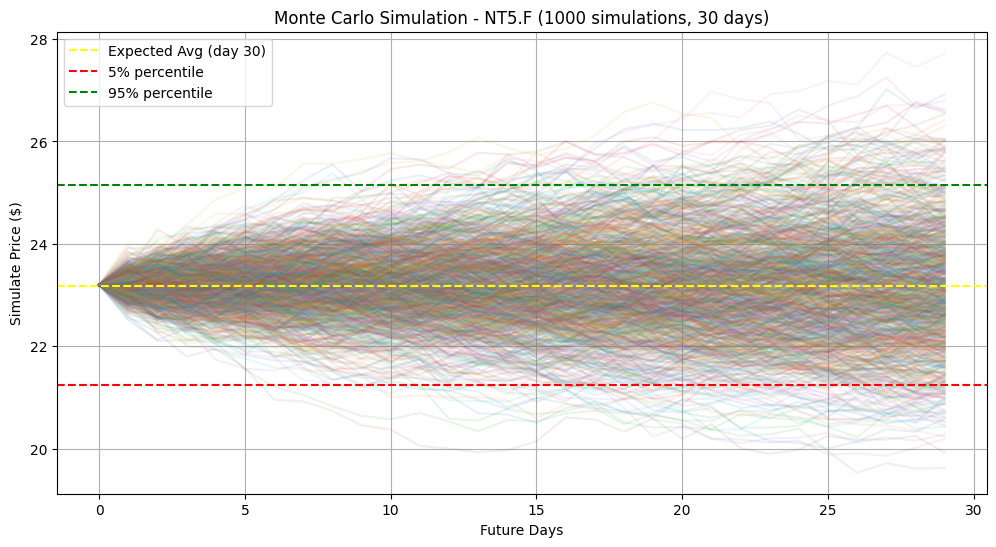

Last price: $23.20
 Expected price 30 days: $23.17
 Conf.Interval (90%): $21.25 - $25.16


In [23]:
prices = nttdata['Close']
last_price = float(prices.iloc[-1])

#Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()
mu = log_returns.mean()
sigma = log_returns.std()

#Parameters:
n_simulations = 1000
n_days = 30
# 252 trading days 
dt = 1 / 252 

#Monte Carlo function with drift + shock
def stock_monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price

    for t in range(1, days):
        shock = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        drift = mu * dt
        price[t] = price[t - 1] + (price[t - 1] * (drift + shock))

    return price

simulations = np.zeros((n_days, n_simulations))

for i in range(n_simulations):
    simulations[:, i] = stock_monte_carlo(last_price, n_days, mu, sigma)

#Stats
expected_price_60 = simulations[-1].mean()
conf_interval = np.percentile(simulations[-1], [5, 95])

#Plot
plt.figure(figsize=(12, 6))
plt.plot(simulations, alpha=0.1)
plt.title(f"Monte Carlo Simulation - NT5.F ({n_simulations} simulations, {n_days} days)")
plt.xlabel("Future Days")
plt.ylabel("Simulate Price ($)")
plt.axhline(expected_price_60, color='yellow', linestyle='--', label=f'Expected Avg (day {n_days})')
plt.axhline(conf_interval[0], color='red', linestyle='--', label='5% percentile')
plt.axhline(conf_interval[1], color='green', linestyle='--', label='95% percentile')
plt.legend()
plt.grid(True)
plt.show()

print(f"Last price: ${last_price:.2f}")
print(f" Expected price {n_days} days: ${expected_price_60:.2f}")
print(f" Conf.Interval (90%): ${conf_interval[0]:.2f} - ${conf_interval[1]:.2f}")


Pipeline creation

In [24]:
def run_monte_carlo(stock, year_back=4, n_days=30, n_simulations=1000, start=None, end=None):
    warnings.simplefilter(action='ignore', category=FutureWarning)

    if not start:
        end = datetime.now()
        start = datetime(end.year - year_back, end.month, end.day)
    else:
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)

    df = yf.download(stock, start, end, progress=False)
    prices = df['Close']
    last_price = float(prices.iloc[-1])

    log_returns = np.log(prices / prices.shift(1)).dropna()
    mu = log_returns.mean()
    sigma = log_returns.std()

    dt = 1 / 252 

    def stock_monte_carlo(start_price, days, mu, sigma):
        price = np.zeros(days)
        price[0] = start_price

        for t in range(1, days):
            shock = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
            drift = mu * dt
            price[t] = price[t - 1] + (price[t - 1] * (drift + shock))

        return price


    simulations = np.zeros((n_days, n_simulations))
    for i in range(n_simulations):
        simulations[:, i] = stock_monte_carlo(last_price, n_days, mu, sigma)

    last_date = prices.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_days)

    simulations_df = pd.DataFrame(simulations, index=future_dates)

    last_simulated_price = simulations_df.iloc[-1]
    average_expected_price = last_simulated_price.mean() #take average of 1000 simulations
    
    conf_interval = np.percentile(last_simulated_price, [5, 95])

    print(f"Last price: ${average_expected_price:.2f}, Average expected in {n_days} days: ${average_expected_price:.2f}, 90% CI: ${conf_interval[0]:.2f} - ${conf_interval[1]:.2f}")

    return average_expected_price, average_expected_price

In [25]:
expected_price_MonteCarlo, average_expected_price_MonteCarlo = run_monte_carlo('NT5.F',4,30,1000)

Last price: $23.23, Average expected in 30 days: $23.23, 90% CI: $21.26 - $25.28


ARIMA Model

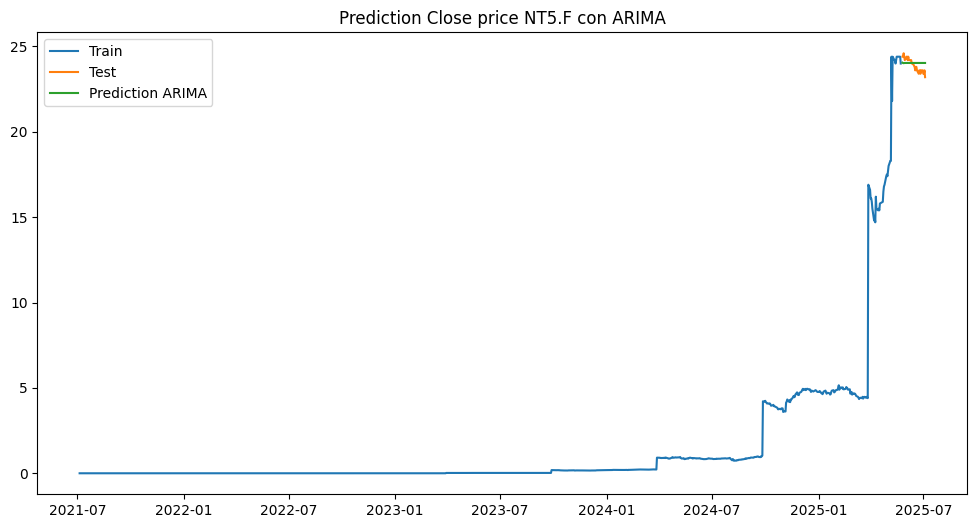

 Last price: $24.03, Average price expected 30 days: $24.03
MAE:  0.3601
RMSE: 0.4103


In [26]:
prices = nttdata['Close']

#Last 30 days for test // All days except last 30 days
train = prices[:-30]
test = prices[-30:]

#Adjust ARIMA (p,d,q) -> p=5, d=1, q=0
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

preds = model_fit.forecast(steps=30)
preds = pd.Series(preds.values, index=test.index)

compare = pd.DataFrame(test)
compare['Prediction'] = preds

#Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(compare.index, compare['Prediction'], label='Prediction ARIMA')
plt.title('Prediction Close price NT5.F con ARIMA')
plt.legend()
plt.show()

expected_price = preds.iloc[-1]
average_expected_price = preds.mean()

print(f" Last price: ${expected_price:.2f}, Average price expected {n_days} days: ${average_expected_price:.2f}")

mae = mean_absolute_error(test, preds)
rmse = np.sqrt(mean_squared_error(test, preds))

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

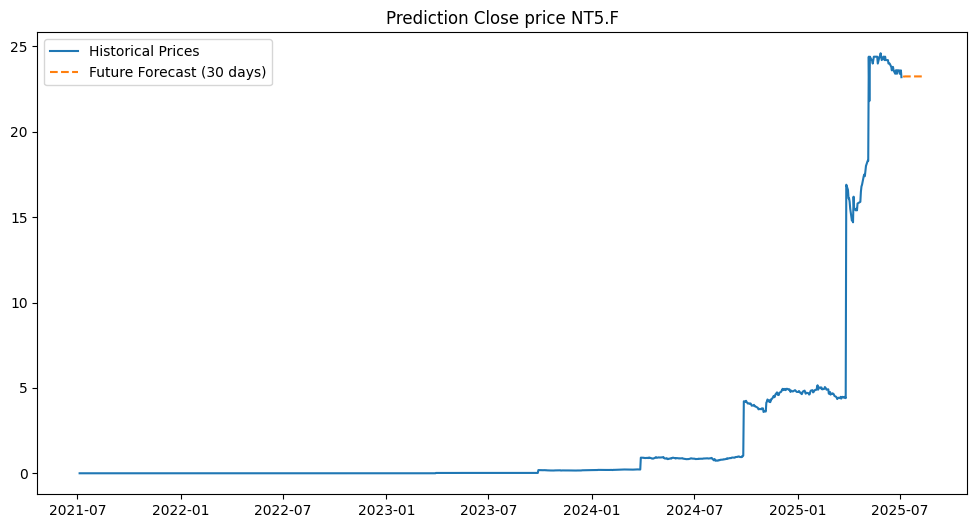

 Last price: $23.24, Average price expected 30 days: $23.24


In [27]:
prices = nttdata['Close']

#Adjust ARIMA (p,d,q) -> p=5, d=1, q=0
model = ARIMA(prices, order=(5,1,0))
model_fit = model.fit()

future_preds = model_fit.forecast(steps=30)
last_date = prices.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)

future_forecast = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds.values})
future_forecast.set_index('Date', inplace=True)

#Plot
plt.figure(figsize=(12,6))
plt.plot(prices.index, prices, label='Historical Prices')
plt.plot(future_forecast.index, future_forecast['Forecast'], label='Future Forecast (30 days)', linestyle='--')
plt.title('Prediction Close price NT5.F')
plt.legend()
plt.show()

expected_price = future_preds.iloc[-1]
average_expected_price = future_preds.mean()

print(f" Last price: ${expected_price:.2f}, Average price expected {n_days} days: ${average_expected_price:.2f}")

In [28]:
def run_ARIMA(stock, year_back = 4, n_days=30, start='2021-07-31', end='2025-07-31'):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    #Start date set to 4 year back
    if not start:
        end = datetime.now()
        start = datetime(end.year-year_back,end.month,end.day) 
    else:
        start = start
        end = end
    
    df = yf.download(stock,start,end,progress=False)
    prices = df['Close']

    #Adjust ARIMA (p,d,q) -> p=5, d=1, q=0
    model = ARIMA(prices, order=(5,1,0))
    model_fit = model.fit()

    future_preds = model_fit.forecast(steps=30)
    last_date = prices.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)

    future_forecast = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds.values})
    future_forecast.set_index('Date', inplace=True)
    
    expected_price = future_preds.iloc[-1]
    average_expected_price = future_preds.mean()
    
    print(f" Last price: ${expected_price:.2f}, Average price expected {n_days} days: ${average_expected_price:.2f}")
    
    return expected_price,average_expected_price

In [29]:
expected_price_ARIMA, average_expected_price_ARIMA = run_ARIMA('NT5.F',4,30)

 Last price: $23.24, Average price expected 30 days: $23.24


# Prepare parts of Mage

## Extract data

In [30]:
def extract_data(stock, year_back = 4):
    end = datetime.now()
    start = datetime(end.year-year_back,end.month,end.day) 
    df = yf.download(stock, start=start, end=end)
    return df[['Close']]


## Preprocess data

In [31]:
def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0,1)) # Initialize MinMaxScaler to normalize the data between 0 and 1
    scaled_df = scaler.fit_transform(df)
    return scaled_df, scaler 

## Prepare data

In [32]:
def prepare_data(scaled_df,last_days=60):
    training_data_len = int(np.ceil(len(scaled_df) * 0.8)) #Define training data length as 80% of the total data
    train_data = scaled_df[0:int(training_data_len),:]
    x_train = []
    y_train = []
    #population x_train with 60 days of data and y_train with the following day's closing price
    for i in range(last_days,len(train_data)):
        x_train.append(train_data[i-last_days:i,0]) # Past 60 days
        y_train.append(train_data[i,0]) # Target for the next day's close price
        
    x_train,y_train = np.array(x_train),np.array(y_train)#Convert list to numpy array for model training
    #Reshape x_train to format [samples,time steps, features ] required for the LSTM
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
    return x_train,y_train

## Model Creation

In [33]:
def define_model(x_train):
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1))) #First LSTM Layer with 50 units and return sequences 
    model.add(Dropout(0.2)) #Dropout layer to prevent overfitting 
    model.add(LSTM(units=50,return_sequences=False)) #Second LSTM Layer with 50 units
    model.add(Dropout(0.2)) #Dropout layer to prevent overfitting
    model.add(Dense(units=25))#Dense layer with 25 units
    model.add(Dense(units=1))#Output layer with 1 unit (the predicted price)
    model.compile(optimizer='adam', loss= 'mean_squared_error')#Compile the model using "ADAM" optimizer and mean squared error as the loss function
    return model

## Train the Model

In [34]:
#Train the model with batch size of 1 and 1 epoch (adjust epoch count for better results)
def train_model(model,x_train,y_train):
    model.fit(x_train,y_train, batch_size = 1, epochs=1)
    return model

## Prepare data for 30 days forecast and Generate 30 days forecast

In [35]:
def test_model(name_stock='NT5.F',last_days=60,days_to_predict=30):
    nttdata = extract_data(name_stock)
    scaled_nttdata, scaler = preprocess_data(nttdata)
    last_60_days_nttdata = scaled_nttdata[-last_days:]
    x_future = last_60_days_nttdata.reshape((1,last_60_days_nttdata.shape[0],1)) # Reshape last 60 days to fit the model input shape (1 sample, 60 times, 1 feature)
    #model creation
    x_train, y_train = prepare_data(scaled_nttdata)
    def_model = define_model(x_train)
    #train model
    model = train_model(def_model,x_train,y_train)
    #predictions
    future_predictions = [] # create a empty list to store predictions for the next 30 days
    for _ in range(days_to_predict):
        pred = model.predict(x_future) #Predict the next days closing price based on the last 60 days 
        future_predictions.append(pred[0,0]) # Add prediction to the list 
    #Update x_future with the new prediction by removing the first value and adding the new prediction
    x_future = np.append(x_future[:,1:, :], [[pred[0]]],axis=1)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))#transform predictions back to the original scale. Convert the scaled predictions back to the original scale using inverse_Transform
    # Visualize the results 
    # Create a Dataframe to hold the 30-day forecast with dates 
    forecast_dates = pd.date_range(start=nttdata.index[-1] + pd.Timedelta(days=1), periods=30,freq='B')
    forecast = pd.DataFrame(future_predictions,index=forecast_dates,columns=['Prediction'])
    print(f" Last price: ${forecast['Prediction'].iloc[-1]:.2f}, Average price expected {n_days} days: ${forecast['Prediction'].mean():.2f}")
    return forecast, nttdata,forecast['Prediction'].iloc[-1],forecast['Prediction'].mean()

In [36]:
forecast, nttdata, expected_price_LSTM, average_expected_price_LSTM= test_model('NT5.F',60,30)

[*********************100%***********************]  1 of 1 completed


759/759 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 8.8178e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

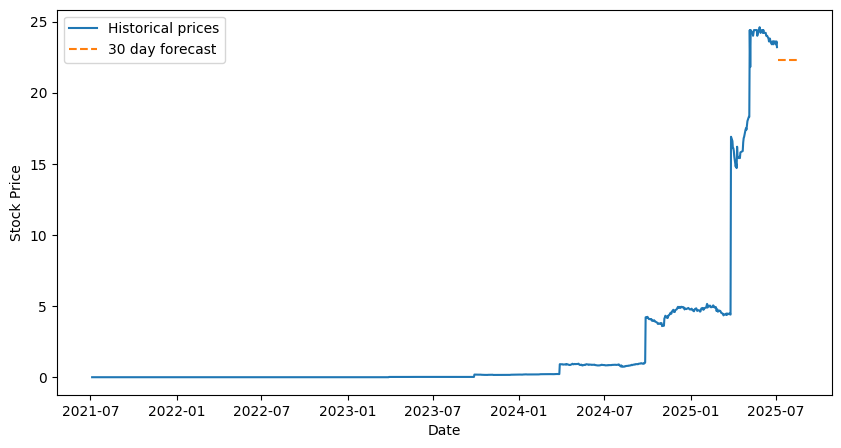

In [37]:
#Plot historical data and future predictions for comparison
plt.figure(figsize=(10,5))
plt.plot(nttdata['Close'],label='Historical prices')
plt.plot(forecast['Prediction'],label= '30 day forecast',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [38]:
hybrid_expected_price = (float(expected_price_MonteCarlo) + float(expected_price_ARIMA) + float(expected_price_LSTM)) / 3
hybrid_average_expected_price = (float(average_expected_price_MonteCarlo)+float(average_expected_price_ARIMA)+float(average_expected_price_LSTM)) / 3
print(f'Price expected for the next 30 days ${hybrid_expected_price:.2f}')
print(f'Average price expected for the next 30 days ${hybrid_average_expected_price:.2f}')

Price expected for the next 30 days $22.92
Average price expected for the next 30 days $22.92
